
# Unsupervised Review Clusters (Multilingual, No Hard-Coded Intents)

This notebook builds *unsupervised* clusters from review text only (Yelp/Reddit/Wikivoyage), then exports:
- `nlp/review_clusters.npz` (centroids and config)
- `nlp/review_cluster_assignments.csv` (place -> cluster)

It also produces diagnostic visualizations:
- UMAP plot of clusters (optional)
- c-TF-IDF top terms per cluster (with multilingual stopwords)
- Cluster size bar chart

> **No hand-coded intent**: the clusters are derived purely from the review corpus using sentence-transformer embeddings and KMeans.  


In [2]:
# --- Bootstrap local imports (run first) ---
import sys, os
from pathlib import Path

# Heuristic: find repo root (must contain kg/ and central_model.py)
here = Path.cwd()
candidates = [here, *here.parents]
PROJECT_ROOT = None
for p in candidates:
    if (p / "kg").is_dir() and (p / "central_model.py").exists():
        PROJECT_ROOT = p
        break

# If not found automatically, set manually:
# PROJECT_ROOT = Path("/absolute/path/to/tourism-rag")

if PROJECT_ROOT is None:
    raise RuntimeError("Couldn't find project root containing 'kg/' and 'central_model.py'. "
                       "Open this notebook from your repo root or set PROJECT_ROOT manually.")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
os.chdir(PROJECT_ROOT)

print("Project root:", PROJECT_ROOT)


Project root: /Users/chaayagirimon/Shelf/thesis/tourism-rag


In [3]:

%load_ext autoreload
%autoreload 2

import os, sys, json, math, re, random, subprocess
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Project imports
from kg.neo4j_client import KG
from central_model import get_st_model

# Reproducibility
random.seed(42); np.random.seed(42)

# Paths
OUT_DIR = Path('nlp'); OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CENTROIDS = OUT_DIR / 'review_clusters.npz'
OUT_ASSIGN_CSV = OUT_DIR / 'review_cluster_assignments.csv'
FIG_DIR = Path('./figs'); FIG_DIR.mkdir(parents=True, exist_ok=True)

# Notebook knobs
K = 12                             # default number of clusters (will be auto-tuned if AUTO_K=True)
AUTO_K = True                      # try candidate K's and pick by silhouette on cosine distances
K_CANDIDATES = [8, 10, 12, 14, 16] # used if AUTO_K=True
BATCH_KMEANS = True                # MiniBatchKMeans for speed
MAX_PLACES = 50000                 # cap sampled places
MAX_REVS_PER_PLACE = 120           # reviews cap per place
MIN_REVIEW_LEN = 40                # sentence length cutoff
UMAP_N = 3000                      # subsample for 2D plot
TOP_TERMS = 20                     # top terms per cluster
CITY_FILTER = None                 # or a city name present in KG City nodes
SENT_CAP_PER_SOURCE = 80           # limit sentences per source to avoid domination by one review
TRIM_RATIO = 0.1                   # trimmed mean: drop top/bottom 10% sentence embeddings before mean


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

def kg_run(kg, cypher: str, params: dict | None = None):
    """Run a Cypher query and return list of dicts."""
    with kg._driver.session() as s:
        res = s.run(cypher, **(params or {}))
        return [r.data() for r in res]

def sentence_chunks(text: str, min_len: int = 40):
    parts = re.split(r'(?<=[.!?])\s+', (text or '').strip())
    for p in parts:
        s = p.strip()
        if len(s) >= min_len:
            yield s[:1000]

def fetch_place_ids(kg, city: str | None, limit: int):
    # Prefer IN_CITY relationship; fallback to all places.
    if city:
        q = '''
        MATCH (cp:CanonicalPlace)-[:IN_CITY]->(c:City {name:$city})
        RETURN cp.id AS id
        LIMIT $limit
        '''
        rows = kg_run(kg, q, {"city": city, "limit": limit})
        if rows:
            return [r["id"] for r in rows]
    q = '''
    MATCH (cp:CanonicalPlace)
    RETURN cp.id AS id
    LIMIT $limit
    '''
    rows = kg_run(kg, q, {"limit": limit})
    return [r["id"] for r in rows]

def trimmed_mean_pool(embs: np.ndarray, trim_ratio: float = 0.1) -> np.ndarray:
    """Trimmed mean over sentence embeddings along axis=0."""
    if embs.ndim != 2 or embs.shape[0] < 3:
        return embs.mean(axis=0)
    lo = int(math.floor(trim_ratio * embs.shape[0]))
    hi = int(math.ceil((1.0 - trim_ratio) * embs.shape[0]))
    # project onto first PC for stable trimming
    u, s, vh = np.linalg.svd(embs - embs.mean(0), full_matrices=False)
    proj = u[:, 0]  # 1D projection
    order = np.argsort(proj)
    kept = order[lo:hi]
    return embs[kept].mean(axis=0)

def place_review_vector(model, reviews, max_revs=120, min_len=40, per_source_cap=80, trim_ratio=0.1):
    # Harvest sentences with per-source caps to avoid Yelp-only dominance etc.
    sents = []
    per_src = {}
    for rv in reviews[:max_revs]:
        t = (rv.get("text") or "").strip()
        src = (rv.get("src") or "other").lower()
        if not t:
            continue
        per_src.setdefault(src, 0)
        if per_src[src] >= per_source_cap:
            continue
        for s in sentence_chunks(t, min_len=min_len):
            sents.append(s)
            per_src[src] += 1
            if per_src[src] >= per_source_cap:
                break
    if not sents:
        return None
    embs = model.encode(sents, normalize_embeddings=True, convert_to_numpy=True)
    return trimmed_mean_pool(embs, trim_ratio=trim_ratio)

def collect_corpus_for_tfidf(kg, place_ids, max_revs=120):
    corpus = {}
    for pid in place_ids:
        revs = kg.reviews_for([pid]).get(pid, [])
        texts = [(rv.get("text") or "").strip() for rv in revs[:max_revs] if (rv.get("text") or "").strip()]
        corpus[pid] = " ".join(texts)
    return corpus


In [5]:

def _pip_install(pkg):
    try:
        __import__(pkg.split('[')[0])
    except ImportError:
        print(f"Installing {pkg} ...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

# Prefer stopwordsiso (70+ languages)
try:
    import stopwordsiso as stopwordsiso
except ImportError:
    _pip_install('stopwordsiso')
    import stopwordsiso as stopwordsiso

# Optional fallback: NLTK
try:
    import nltk
    from nltk.corpus import stopwords as nltk_stopwords
    try:
        _ = nltk_stopwords.words('english')
    except LookupError:
        nltk.download('stopwords')
except Exception:
    nltk = None
    nltk_stopwords = None

def load_multilingual_stopwords(langs=('en','nl','de','fr','es','it')):
    sw = set()
    for lang in langs:
        try:
            sw |= set(stopwordsiso.stopwords(lang))
        except Exception:
            pass
        if nltk_stopwords:
            code_map = {'en':'english','nl':'dutch','de':'german','fr':'french','es':'spanish','it':'italian'}
            if lang in code_map:
                try:
                    sw |= set(nltk_stopwords.words(code_map[lang]))
                except Exception:
                    pass
    # normalize and prune to align with token_pattern r"(?u)\b\w\w\w+\b"
    cleaned = []
    for w in sw:
        if not w:
            continue
        w = w.strip().lower()
        if len(w) >= 3 and re.fullmatch(r"\w{3,}", w):
            cleaned.append(w)
    return sorted(set(cleaned))

STOPWORDS = load_multilingual_stopwords()
print('Loaded multilingual stopwords:', len(STOPWORDS))

# Tiny blacklist for TF-IDF only (street words / boilerplate tokens)
TFIDF_BLACKLIST = {
    'street','road','avenue','square','platz','straße','rue','utca','calle',
    'laan','laan','via','corso','piazza','carrer','park','bridge','station',
    'airport','hostel','hotel','inn','holiday','radisson','hilton','grand','palace'
}


Loaded multilingual stopwords: 3577


In [6]:

kg = KG()
model = get_st_model()

place_ids = fetch_place_ids(kg, CITY_FILTER, MAX_PLACES)
vecs, keep_ids, names = [], [], []

for pid in place_ids:
    # optional: fetch name (no city property assumed)
    name = None
    try:
        row = kg_run(kg, "MATCH (cp:CanonicalPlace {id:$id}) RETURN cp.name AS name", {"id": pid})
        if row:
            name = row[0].get("name")
    except Exception:
        pass

    revs = kg.reviews_for([pid]).get(pid, [])
    v = place_review_vector(
        model, revs,
        max_revs=MAX_REVS_PER_PLACE,
        min_len=MIN_REVIEW_LEN,
        per_source_cap=SENT_CAP_PER_SOURCE,
        trim_ratio=TRIM_RATIO
    )
    if v is None:
        continue
    vecs.append(v); keep_ids.append(pid); names.append(name or "")

X = np.array(vecs, dtype='float32')
print("Kept places:", len(keep_ids), "Vector dim:", X.shape[1] if X.ndim==2 else None)


Kept places: 11611 Vector dim: 384


In [7]:

from sklearn.metrics.pairwise import cosine_distances

def fit_kmeans_cosine(X, k, minibatch=True):
    # Cosine kmeans via L2-normalized vectors + Euclidean kmeans
    # (cosine distance ~ 1 - dot; with normalized vectors Euclidean relates)
    from sklearn.preprocessing import normalize
    Xn = normalize(X, norm='l2')
    if minibatch:
        km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=2048, n_init='auto')
    else:
        km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(Xn)
    sil = silhouette_score(cosine_distances(Xn), labels, metric='precomputed')
    return km, labels, sil

best_k, best_sil, best_km, best_labels = None, -1.0, None, None

if AUTO_K:
    from sklearn.preprocessing import normalize
    Xn = X / np.maximum(np.linalg.norm(X, axis=1, keepdims=True), 1e-8)
    D = cosine_distances(Xn)  # used for silhouette
    for k in K_CANDIDATES:
        if k >= len(Xn):
            continue
        if BATCH_KMEANS:
            km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=2048, n_init='auto')
        else:
            km = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = km.fit_predict(Xn)
        sil = silhouette_score(D, labels, metric='precomputed')
        print(f"K={k:>2} silhouette={sil:.4f}")
        if sil > best_sil:
            best_sil, best_k, best_km, best_labels = sil, k, km, labels
    print(f"Selected K={best_k} (silhouette={best_sil:.4f})")
else:
    best_k = K
    best_km, best_labels, best_sil = fit_kmeans_cosine(X, K, minibatch=BATCH_KMEANS)

labels = best_labels
centroids = best_km.cluster_centers_


/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  

K= 8 silhouette=0.1611


/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/clus

K=10 silhouette=0.1370


/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/clus

K=12 silhouette=0.1289


/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/clus

K=14 silhouette=0.1374


/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/sklearn/clus

K=16 silhouette=0.1431
Selected K=8 (silhouette=0.1611)


In [8]:

np.savez_compressed(OUT_CENTROIDS, centroids=centroids.astype('float32'), k=np.array([best_k], dtype='int32'))
pd.DataFrame({'place_id': keep_ids, 'cluster': labels}).to_csv(OUT_ASSIGN_CSV, index=False)
print("Wrote:", OUT_CENTROIDS)
print("Wrote:", OUT_ASSIGN_CSV)


Wrote: nlp/review_clusters.npz
Wrote: nlp/review_cluster_assignments.csv


/Users/chaayagirimon/miniconda3/envs/scraper/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


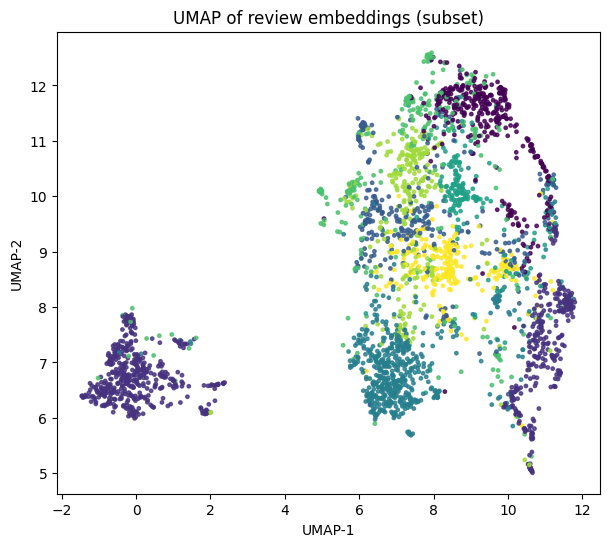

Saved: figs/clusters_umap.png


In [9]:

# --- UMAP visual (optional) ---
try:
    import umap
    SUB = min(UMAP_N, len(X))
    idx = np.random.choice(len(X), size=SUB, replace=False)
    X_sub = X[idx]
    y_sub = labels[idx]
    reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='cosine', random_state=42)
    X_2d = reducer.fit_transform(X_sub)
    plt.figure(figsize=(7,6))
    sc = plt.scatter(X_2d[:,0], X_2d[:,1], c=y_sub, s=6, alpha=0.8)
    plt.title("UMAP of review embeddings (subset)")
    plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
    out = FIG_DIR / "clusters_umap.png"
    plt.savefig(out, dpi=180, bbox_inches='tight')
    plt.show()
    print("Saved:", out)
except Exception as e:
    print("UMAP skipped / failed:", e)


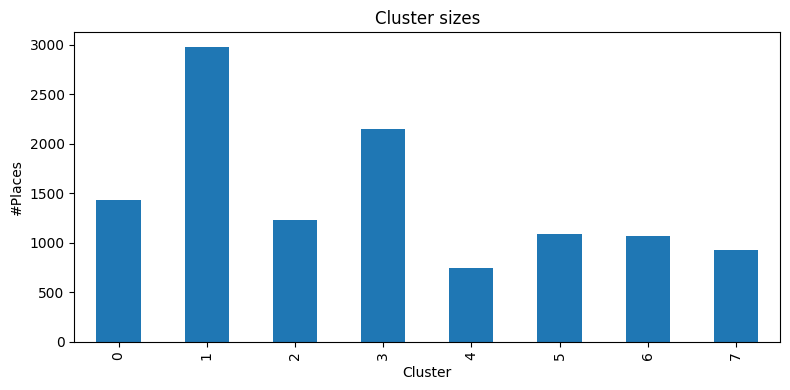

Saved: figs/cluster_sizes.png


In [10]:

# --- Cluster sizes ---
sizes = pd.Series(labels).value_counts().sort_index()
plt.figure(figsize=(8,4))
sizes.plot(kind='bar')
plt.title("Cluster sizes")
plt.xlabel("Cluster"); plt.ylabel("#Places")
out = FIG_DIR / "cluster_sizes.png"
plt.tight_layout(); plt.savefig(out, dpi=180)
plt.show()
print("Saved:", out)


,cluster,top_terms
0,0,"church, san, museum, statue, santa, rome, beau..."
1,1,"food, service, recommend, friendly, nice, deli..."
2,2,"istanbul, museum, church, tér, iii, stockholm,..."
3,3,"london, lane, house, museum, walk, views, cent..."
4,4,"statue, paris, museum, saint, arch, beautiful,..."
5,5,"restaurant, pizzeria, rua, contrada, restauran..."
6,6,"restaurant, rua, resort, city, house, budapest..."
7,7,"museum, university, vienna, city, history, hal..."


Saved top terms CSV -> figs/cluster_top_terms.csv


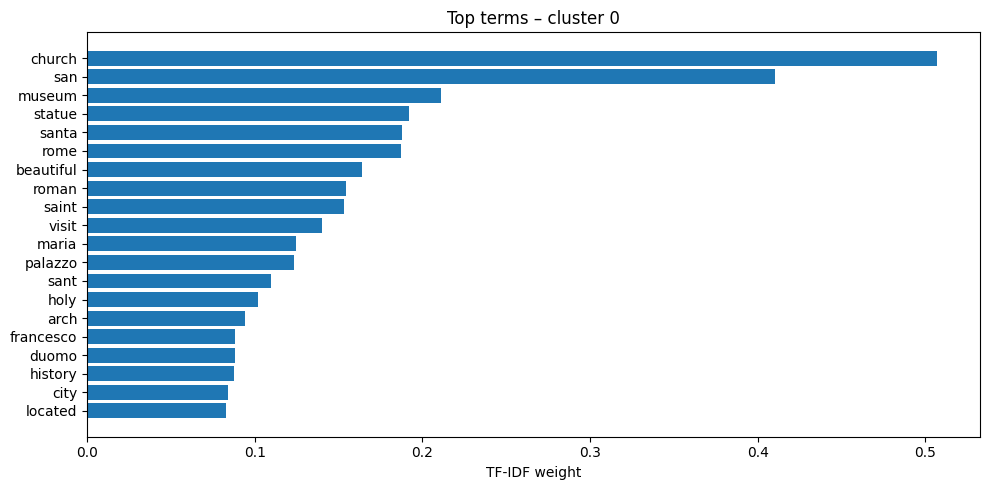

Saved: figs/cluster_0_top_terms.png


In [11]:

# --- c-TF-IDF top terms per cluster ---
corpus_by_place = collect_corpus_for_tfidf(kg, keep_ids)

cluster_docs = ["" for _ in range(best_k)]
for pid, lbl in zip(keep_ids, labels):
    cluster_docs[lbl] += " " + corpus_by_place.get(pid, "")

# Build stopwords with tiny blacklist
stopset = set(STOPWORDS) | TFIDF_BLACKLIST
stoplist = sorted(stopset)

token_pattern = r"(?u)\b\w\w\w+\b"
tfidf = TfidfVectorizer(
    max_features=12000,
    ngram_range=(1, 2),
    min_df=5,
    stop_words=stoplist,   # LIST (valid for scikit-learn)
    lowercase=True,
    token_pattern=token_pattern,
)

W = tfidf.fit_transform(cluster_docs)  # [K, V]
terms = np.array(tfidf.get_feature_names_out())

rows = []
for c in range(best_k):
    row = W[c].toarray()[0]
    if row.sum() == 0:
        rows.append({"cluster": c, "top_terms": ""})
        continue
    top_idx = row.argsort()[-TOP_TERMS:][::-1]
    rows.append({"cluster": c, "top_terms": ", ".join(terms[top_idx])})

df_terms = pd.DataFrame(rows)
display(df_terms)
CSV_TOPTERMS = FIG_DIR / "cluster_top_terms.csv"
df_terms.to_csv(CSV_TOPTERMS, index=False)
print("Saved top terms CSV ->", CSV_TOPTERMS)

# Bar for a sample cluster
CLUSTER_TO_PLOT = 0
vec = W[CLUSTER_TO_PLOT].toarray()[0]
top_idx = vec.argsort()[-TOP_TERMS:][::-1]
plt.figure(figsize=(10,5))
plt.barh(range(TOP_TERMS), vec[top_idx][::-1])
plt.yticks(range(TOP_TERMS), terms[top_idx][::-1])
plt.xlabel("TF-IDF weight")
plt.title(f"Top terms – cluster {CLUSTER_TO_PLOT}")
plt.tight_layout()
out = FIG_DIR / f"cluster_{CLUSTER_TO_PLOT}_top_terms.png"
plt.savefig(out, dpi=180)
plt.show()
print("Saved:", out)


In [12]:

cfg = {
    "k": int(best_k),
    "auto_k": bool(AUTO_K),
    "k_candidates": K_CANDIDATES,
    "batch_kmeans": bool(BATCH_KMEANS),
    "max_places": int(MAX_PLACES),
    "max_reviews_per_place": int(MAX_REVS_PER_PLACE),
    "min_review_len": int(MIN_REVIEW_LEN),
    "per_source_sentence_cap": int(SENT_CAP_PER_SOURCE),
    "trim_ratio": float(TRIM_RATIO)
}
CFG_PATH = OUT_DIR / "review_cluster_config.json"
with open(CFG_PATH, "w") as f:
    json.dump(cfg, f, indent=2)
print("Saved config ->", CFG_PATH)


Saved config -> nlp/review_cluster_config.json
